Problem statement:

![imgae](https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/HMMGraph.svg/1024px-HMMGraph.svg.png)

In [2]:
from collections import Counter

import arviz
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
import tqdm
from jax import random
from numpyro.infer import MCMC, NUTS

numpyro.set_host_device_count(4)

rng_key = random.PRNGKey(10)

In [3]:
weather = {0: "rainy", 1: "sunny"}
activity = {0: "walk", 1: "shop", 2: "clean"}

transition_prob = jnp.array([[0.7, 0.3], [0.4, 0.6]])

emission_prob = jnp.array([[0.1, 0.4, 0.5], [0.6, 0.3, 0.1]])
start_prob = jnp.array([0.6, 0.4])
start_prob, transition_prob, emission_prob
# dist.Categorical(start_prob).sample()

(DeviceArray([0.6, 0.4], dtype=float32),
 DeviceArray([[0.7, 0.3],
              [0.4, 0.6]], dtype=float32),
 DeviceArray([[0.1, 0.4, 0.5],
              [0.6, 0.3, 0.1]], dtype=float32))

In [4]:
# simulate data
num_data = 200
weathers, activities = [], []
_weather = dist.Categorical(start_prob).sample(rng_key)
subkeys = random.split(key=rng_key, num=num_data)
for i, subkey in enumerate(subkeys):
    _weather = dist.Categorical(transition_prob[_weather]).sample(subkey)
    subsub_key = random.split(key=subkey, num=1)[0]
    _activity = dist.Categorical(emission_prob[_weather]).sample(subsub_key)
    weathers.append(int(_weather))
    activities.append(int(_activity))
activities = jnp.array(activities)
weathers = jnp.array(weathers)
jnp.unique(activities[weathers == 0], return_counts=True), jnp.unique(
    activities[weathers == 1], return_counts=True
), emission_prob[1], jnp.unique(weathers, return_counts=True)

((DeviceArray([0, 1, 2], dtype=int32), DeviceArray([11, 53, 47], dtype=int32)),
 (DeviceArray([0, 1, 2], dtype=int32), DeviceArray([42, 35, 12], dtype=int32)),
 DeviceArray([0.6, 0.3, 0.1], dtype=float32),
 (DeviceArray([0, 1], dtype=int32), DeviceArray([111,  89], dtype=int32)))

In [5]:
def model(activities, weathers):

    transition_prior = numpyro.sample(
        "transition_prob", dist.Dirichlet(jnp.ones((2, 2)) / 2)
    )
    emission_prior = numpyro.sample(
        "emission_prob", dist.Dirichlet(jnp.ones((2, 3)) / 3)
    )

    current_weather = weathers[0]
    weathers = weathers[1:]
    activities = activities[1:]

    with numpyro.plate("test", 1):
        for i, (activity, weather) in enumerate(zip(activities, weathers)):
            current_weather = numpyro.sample(
                f"weather_{i}",
                dist.Categorical(transition_prior[current_weather]),
                obs=weathers[i],
            )
            _activity = numpyro.sample(
                f"act_{i}",
                dist.Categorical(emission_prior[current_weather]),
                obs=activities[i],
            )

In [9]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=200, num_chains=4, chain_method="sequential")
mcmc.run(rng_key, activities, weathers)

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 700/700 [00:00<00:00, 2191.14it/s, 7 steps of size 6.91e-01. acc. prob=0.91]


In [10]:
mcmc.print_summary()


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  emission_prob[0,0]      0.10      0.03      0.10      0.06      0.15    795.96      1.00
  emission_prob[0,1]      0.48      0.05      0.47      0.40      0.56   1351.00      1.00
  emission_prob[0,2]      0.42      0.05      0.42      0.35      0.50   1510.72      1.00
  emission_prob[1,0]      0.47      0.05      0.47      0.39      0.56   1029.86      1.00
  emission_prob[1,1]      0.39      0.05      0.39      0.30      0.47   1077.59      1.00
  emission_prob[1,2]      0.14      0.03      0.14      0.08      0.19   1319.25      1.00
transition_prob[0,0]      0.71      0.04      0.71      0.64      0.77   1289.22      1.00
transition_prob[0,1]      0.29      0.04      0.29      0.23      0.36   1289.22      1.00
transition_prob[1,0]      0.36      0.05      0.36      0.29      0.44    862.86      1.00
transition_prob[1,1]      0.64      0.05      0.64      0.56      0.71    862.86      1.0

array([[<AxesSubplot: title={'center': 'emission_prob\n0, 0'}>,
        <AxesSubplot: title={'center': 'emission_prob\n0, 1'}>,
        <AxesSubplot: title={'center': 'emission_prob\n0, 2'}>],
       [<AxesSubplot: title={'center': 'emission_prob\n1, 0'}>,
        <AxesSubplot: title={'center': 'emission_prob\n1, 1'}>,
        <AxesSubplot: title={'center': 'emission_prob\n1, 2'}>],
       [<AxesSubplot: title={'center': 'transition_prob\n0, 0'}>,
        <AxesSubplot: title={'center': 'transition_prob\n0, 1'}>,
        <AxesSubplot: title={'center': 'transition_prob\n1, 0'}>],
       [<AxesSubplot: title={'center': 'transition_prob\n1, 1'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

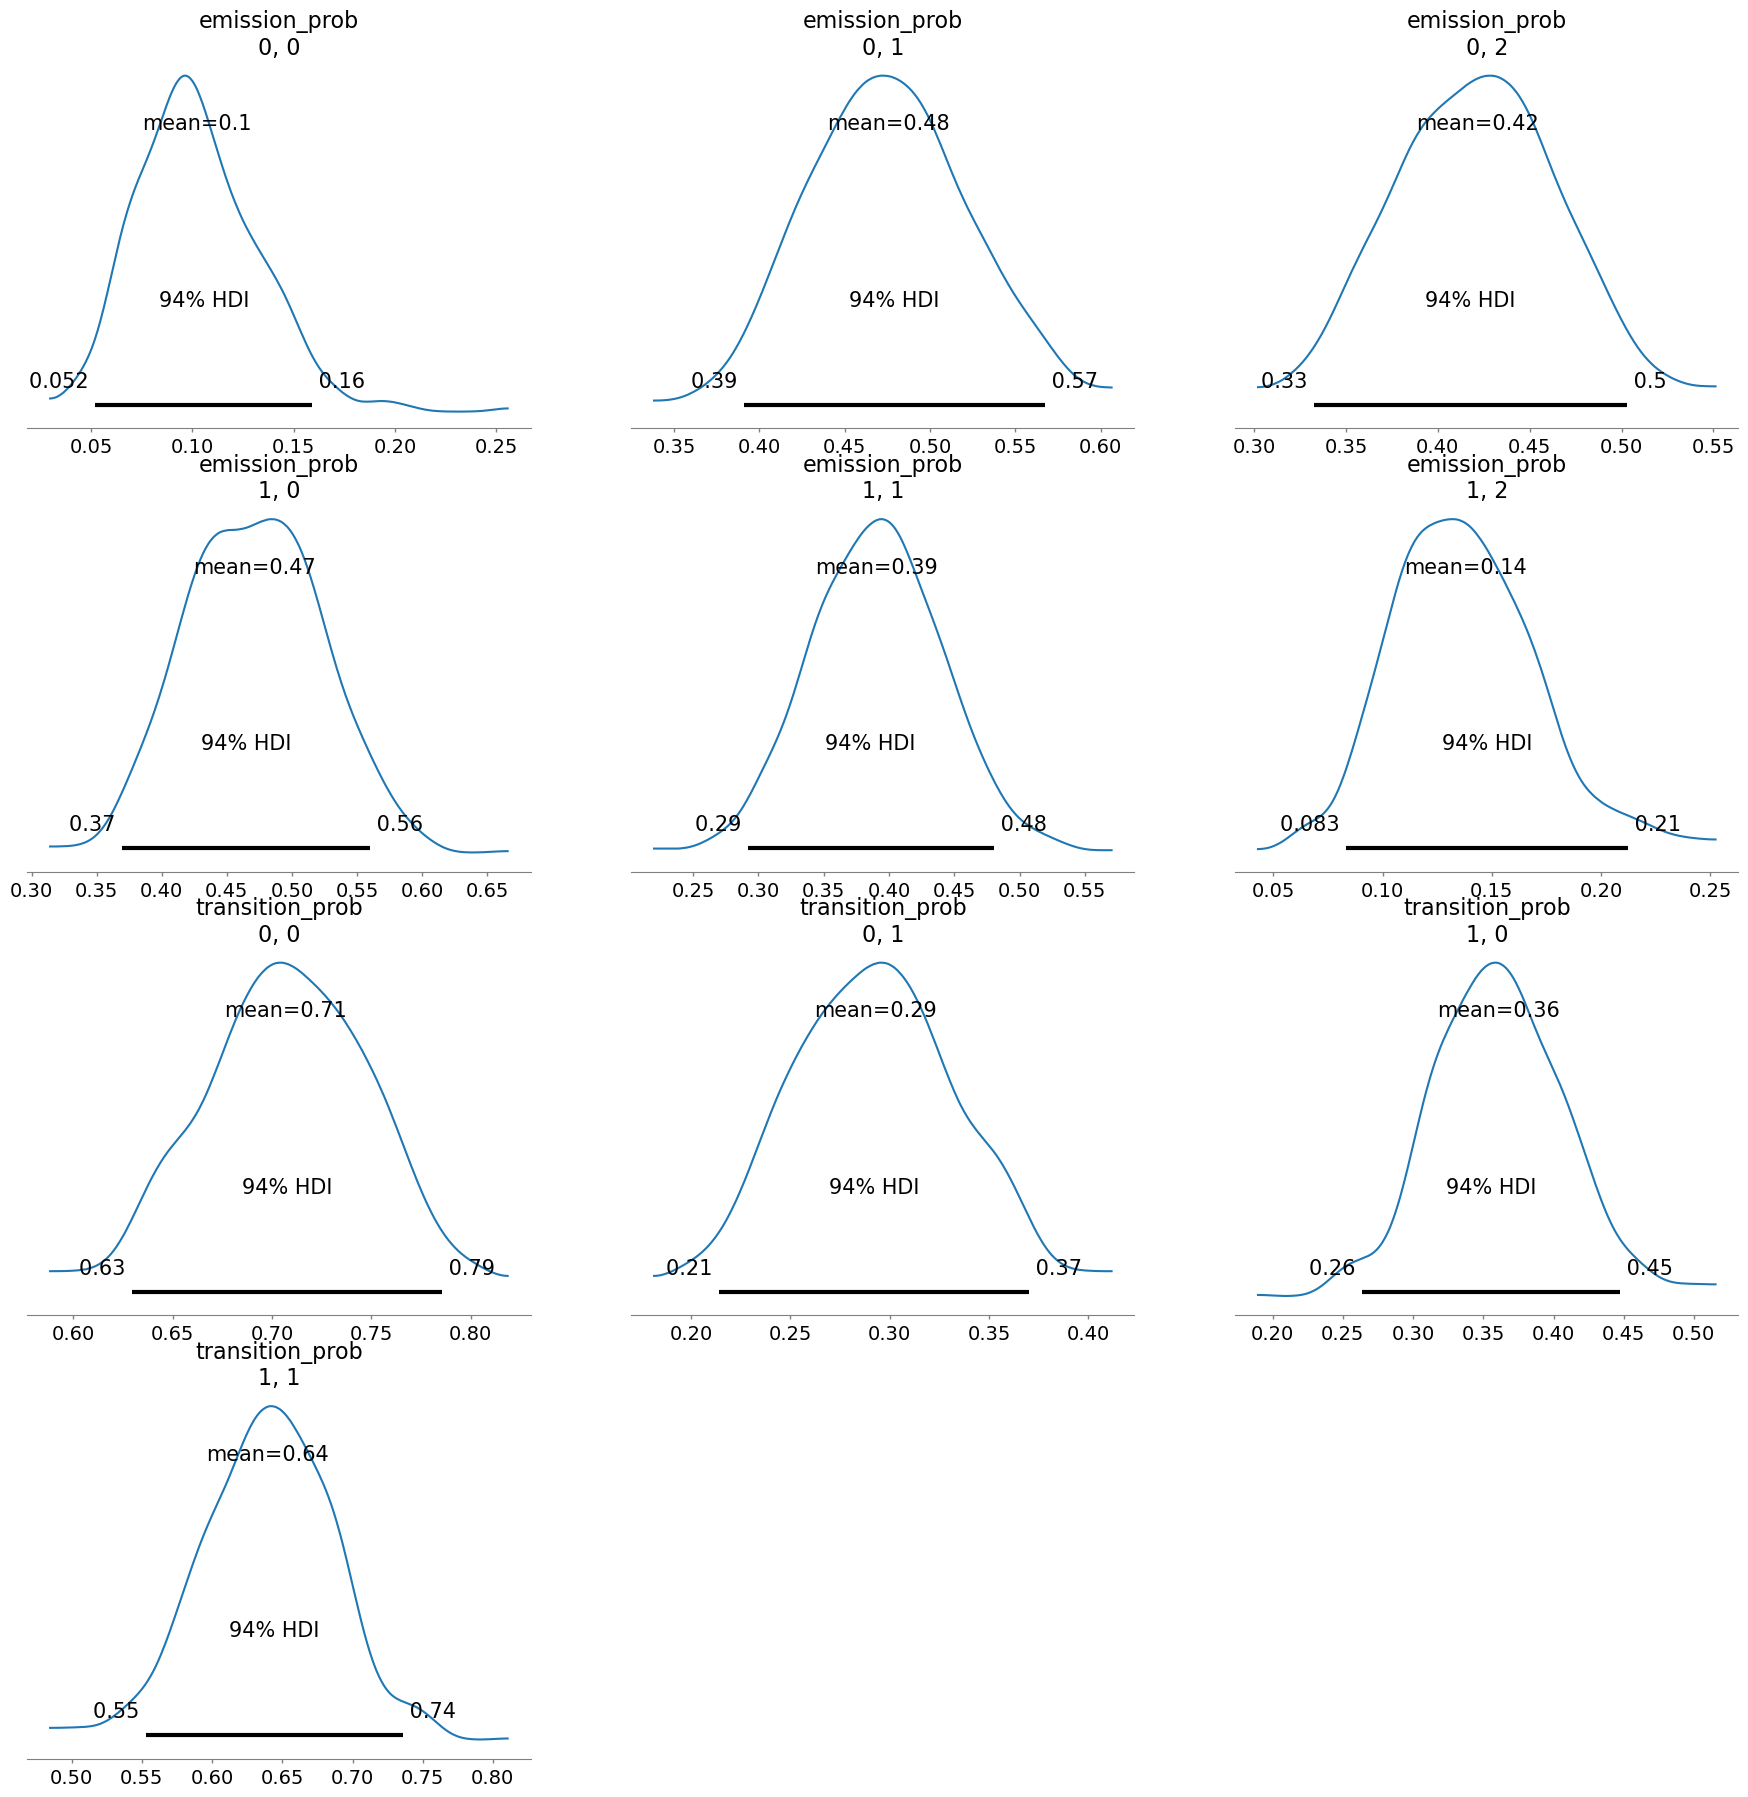

In [8]:
obj = arviz.from_numpyro(mcmc)
arviz.plot_posterior(obj)